In [2]:
import pandas as pd
import numpy as np
import json
import re
import gzip
import spacy

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
/anaconda3/lib/python3.6/site-packages/_pytest/fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
/anaconda3/lib/python3.6/site-packages/_pytest/fixtures.py:846: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)


In [15]:
import nltk
from nltk import FreqDist

In [16]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

In [55]:
df = pd.read_csv('dataset/export_export_reviews (1).csv',header=0)

In [56]:
# Check if all foreign languages have translation
review = df.copy()

# nan_body_rows = review[review['Body'].isnull()]

# nan_sub_rows = review[review['Subject'].isnull()]

In [57]:
# Fill nan translated body and subject with original body and subject
review['Translated Subject'] = review['Translated Subject'].fillna(review['Subject'])
review['Translated Body'] = review['Translated Body'].fillna(review['Body'])

In [58]:
review['text'] = review['Translated Subject'] + review['Translated Body']

In [59]:
# remove null value
reviews = review['text'].dropna()

In [60]:
reviews = reviews.astype(str)

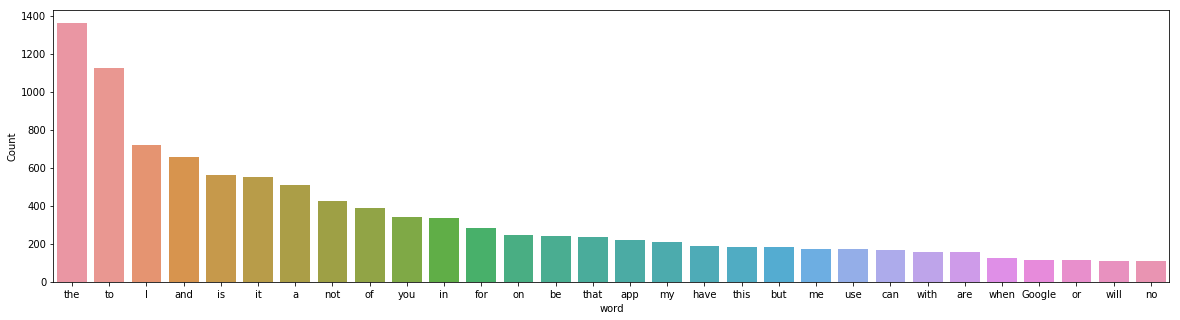

In [61]:
freq_words(reviews)

In [62]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [63]:
# function to remove stopwords
def remove_stopwords(rev):
  rev_new = " ".join([i for i in rev if i not in stop_words])
  return rev_new

In [64]:
# remove short words (length < 3)
reviews = reviews.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in reviews]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

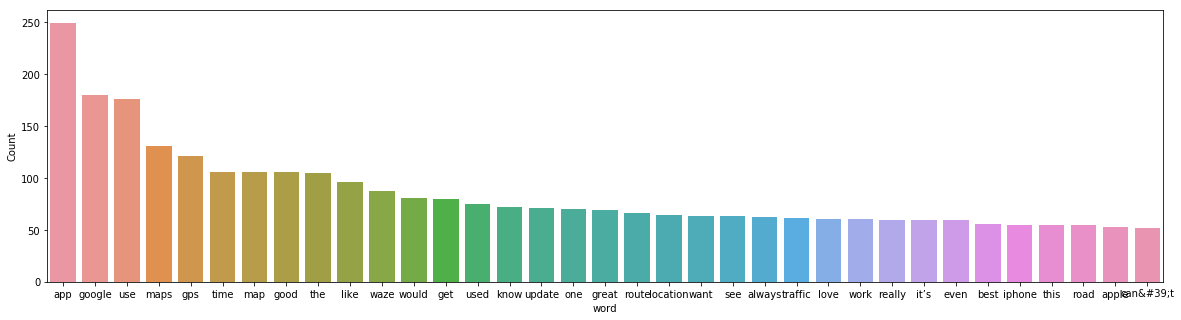

In [65]:
freq_words(reviews, 35)

In [67]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [68]:
def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [69]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['blankafter', 'downloading,', 'can&#39;t', 'use', 'it.']


In [70]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1])

['blankafter', 'downloading', 'can&#39;t', 'use']


In [71]:
set(tokenized_reviews[1]) - set(reviews_2[1])

{'downloading,', 'it.'}

In [74]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

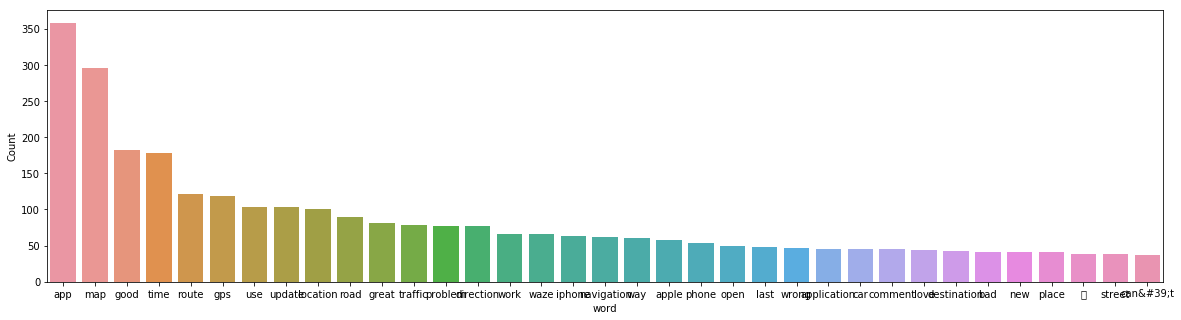

In [75]:
freq_words(reviews_3, 35)

In [76]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_2)

In [77]:
# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [78]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [79]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=7, 
                random_state=100,
                chunksize=1000,
                passes=50)

In [80]:
lda_model.print_topics()

[(0,
  '0.078*"app" + 0.031*"time" + 0.027*"gps" + 0.025*"route" + 0.022*"problem" + 0.020*"map" + 0.019*"good" + 0.014*"traffic" + 0.013*"location" + 0.013*"great"'),
 (1,
  '0.023*"application" + 0.022*"road" + 0.016*"voice" + 0.012*"place" + 0.011*"music" + 0.010*"people" + 0.009*"option" + 0.009*"journey" + 0.008*"safe" + 0.008*"light"'),
 (2,
  '0.024*"car" + 0.024*"star" + 0.010*"good" + 0.010*"music" + 0.009*"last" + 0.008*"service" + 0.007*"place" + 0.007*"gps" + 0.007*"map" + 0.006*"software"'),
 (3,
  '0.020*"gps" + 0.015*"destination" + 0.013*"address" + 0.012*"home" + 0.011*"error" + 0.009*"group" + 0.009*"street" + 0.007*"waze" + 0.007*"correct" + 0.007*"road"'),
 (4,
  '0.023*"waze" + 0.021*"route" + 0.016*"map" + 0.014*"turn" + 0.013*"street" + 0.011*"driver" + 0.011*"search" + 0.011*"voice" + 0.009*"multiple" + 0.008*"easy"'),
 (5,
  '0.032*"apple" + 0.024*"app" + 0.022*"carplay" + 0.021*"open" + 0.015*"comment" + 0.013*"can&#39;t" + 0.013*"map" + 0.011*"screen" + 0.009